# CS 584 Final Project - Sentiment Classification with Pandemic Tweets

#### Author: Ishaan Patel

## Section 1: Data Processing

### Section 1.1: Loading the data

In [441]:
import pandas as pd

train_data = pd.read_csv('train.csv', encoding='latin1')
train_data.head(5)


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [442]:
test_data = pd.read_csv('test.csv', encoding='latin1')
test_data.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet
0,1956,46908,0.9921875,13-03-2020,COVID-19 might be presenting online shopping p...
1,711,45663,210,12/3/2020,My right wing coo coo father in law was tellin...
2,1346,46298,310,13-03-2020,I cannot decide if I am the smartest person in...
3,2204,47156,505,14-03-2020,Why are people stock piling what s wrong wit...
4,1265,46217,21113,13-03-2020,Show me where the eggs are. That's all I need ...


In [443]:
# split the data

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

sentiments = ['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Positive']

text_train = train_data['OriginalTweet'].values.astype(str)
label_train = train_data['Sentiment'].values
y = LabelEncoder().fit_transform(label_train)
print(y[:12])


text_test = test_data['OriginalTweet'].values.astype(str)

[t.encode('utf-8') for t in text_train]
[t.encode('utf-8') for t in text_test]

text_train, text_valid, label_train, label_valid = train_test_split(text_train, y, test_size=0.25)

print('The size of training set:', text_train.shape[0])
print('The size of validation set:', text_valid.shape[0])
print('The size of test set:', text_test.shape[0])

[3 4 4 4 0 4 4 3 4 2 3 1]
The size of training set: 30867
The size of validation set: 10290
The size of test set: 3798


### Section 1.2: Preprocessing of Data


In [444]:
import re
import string
from string import punctuation
from nltk.corpus import stopwords

numbers = '0123456789'
stop = stopwords.words('english') # english stopwords

# preprocesses a givne text
def removal(text):
    # removes punctuation 
    def remove_punc(text):
        for char in punctuation:
            text = text.replace(char, '')
        return text

    # it removes numbers
    def remove_numbers(text):
        for num in numbers:
            text = text.replace(num, '')
        return text

    # makes a string lower case
    def lowercase(text):
        text = text.lower()
        return text

    # remove links
    def remove_links(text):
        text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text)
        return text

    # remove twitter ids and hashtags
    def remove_id(text):
        words = text.split()
        new_text = ''
        for word in words:
            if word[0] != '@' and word[0] != '#':
                new_text += word + ' '
        return new_text

    # it removes stopwords
    def remove_stopwords(text):
        tokens = text.split()
        for word in tokens:
            if word in stop:
                tokens.remove(word)
        return ' '.join(tokens)

    text = remove_id(text)
    text = lowercase(text)
    text = remove_links(text)
    text = remove_punc(text)
    text = remove_numbers(text)
    text = remove_stopwords(text)
    #text = re.sub(r'\s+', ' ', text)
    
    return text

def apply(arr):
    for i in range(len(arr)):
        arr[i] = removal(arr[i])
    return arr

### Section 1.3: Word Embeddings


In [445]:
x_train = apply(text_train)
x_label = label_train
y_train = apply(text_valid)
y_label = label_valid
z_test = apply(text_test)

print(x_train[:3], x_label[:3])
print(y_train[:3], y_label[:3])
print(z_test[:3])


['hi jeeturaj please amp tell people can get test done at affordable prices currently test rates r touching sky k is than salary many people mumbai amp maharash'
 'your donations have able stock and prepare our drive thru food bank distribution tomorrow you would like volunteer please visit'
 'hereâ\x92s idea you a car live local a supermarket leave for elderly vulnerable wouldnâ\x92t be great they somewhere local us young uns dedicate them iâ\x92d happily donate cover more expensive prices'] [4 4 1]
['super mercado en cuarentena groccery shopping panama cityâ'
 'thereâ\x92s plenty food the supply chain the profiteering products at top prices believe waitrose always pricey low offenders the sainsburys tescoâ\x92s really coining in'
 'following initial offers last week bank rolled additional consumer small business offers response the crisis offers include assistance small business loans overdraft fees learn more'] [4 2 0]
['covid might presenting online shopping platforms greatest oppo

In [446]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

# build the tokenizer for the training data
tokenizer = Tokenizer(num_words=5000, lower=True, split=' ', char_level=False)
tokenizer.fit_on_texts(x_train)
embed_train = tokenizer.texts_to_sequences(x_train)

#building the tokenizer for the validation data
#tokenizer.fit_on_texts(y_train)
embed_valid = tokenizer.texts_to_sequences(y_train)

# padding the embeddings
padded_train = pad_sequences(embed_train)
padded_valid = pad_sequences(embed_valid)
maxlength = max(padded_train.shape[1], padded_valid.shape[1])
padded_train = pad_sequences(padded_train, maxlen=maxlength)
padded_valid = pad_sequences(padded_valid, maxlen=maxlength)

# need to build a vocab for the training data
sentences = tokenizer.sequences_to_texts(embed_train)
tokens = []
for sentence in sentences:
    tokens.append(sentence.split())

tokens = list(map(' '.join, tokens))

# building the vocab
vocab = defaultdict(lambda: 0)
for text in tokens:
    words = text.split()
    for word in words:
        vocab[word] += 1
vocab = dict(sorted(vocab.items(), key=lambda x: x[1], reverse=True))

# sentence length should match up
print(padded_train.shape, padded_valid.shape)
print(padded_train[0])
print(padded_valid[0])

pairs = iter(vocab.items())
for i in range(5):
    print(next(pairs))

print(len(vocab.keys()))

padded_train = np.asarray(padded_train).astype(np.int)
padded_valid = np.asarray(padded_valid).astype(np.int)
x_label = np.asarray(x_label).astype(np.int)
y_label = np.asarray(y_label).astype(np.int)


(30867, 41) (10290, 41)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0  903   51   10  544    9   59   19  507  358   98 1426    4  628
  507 1051  867 1391 2363  688   15  301 2797   68    9 3331   10]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0 1183 3443   16]
('the', 17933)
('covid', 7848)
('a', 6552)
('prices', 5842)
('store', 5007)
4999


## Section 2: Neural Networks

### Section 2.1: Simple RNN

In [447]:
# parameters to modify
embed_size = 64
epochs = 10
batch_size = 64
input = len(vocab.keys())+1
lr = 0.001

In [448]:
from keras import layers
from keras.layers import Embedding, LSTM, Dense, BatchNormalization
from tensorflow.keras.optimizers import SGD

# Build the simple RNN model
model1 = keras.Sequential()

# Embedding layer
model1.add(Embedding(input_dim=input, output_dim = embed_size))

# LSTM layer
model1.add(LSTM(units=embed_size, dropout=0.5))

#model1.add(BatchNormalization())
# Dense layer
model1.add(Dense(units=5, activation='softmax'))

# compile the model
model1.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics='accuracy')

# show the model summary for the simple rnn
model1.summary()


Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_60 (Embedding)     (None, None, 64)          320000    
_________________________________________________________________
lstm_55 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_60 (Dense)             (None, 5)                 325       
Total params: 353,349
Trainable params: 353,349
Non-trainable params: 0
_________________________________________________________________


In [449]:
# actually train the model
hist = model1.fit(
    x = padded_train,
    y = x_label,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (padded_valid, y_label)
)

Epoch 1/10
483/483 [==============================] - 37s 72ms/step - loss: 1.3103 - accuracy: 0.4261 - val_loss: 1.0607 - val_accuracy: 0.5799
Epoch 2/10
483/483 [==============================] - 23s 47ms/step - loss: 0.9465 - accuracy: 0.6264 - val_loss: 0.8868 - val_accuracy: 0.6637
Epoch 3/10
483/483 [==============================] - 16s 34ms/step - loss: 0.8015 - accuracy: 0.7017 - val_loss: 0.8335 - val_accuracy: 0.6983
Epoch 4/10
483/483 [==============================] - 16s 34ms/step - loss: 0.7276 - accuracy: 0.7388 - val_loss: 0.8008 - val_accuracy: 0.7057
Epoch 5/10
483/483 [==============================] - 16s 34ms/step - loss: 0.6849 - accuracy: 0.7584 - val_loss: 0.7557 - val_accuracy: 0.7346
Epoch 6/10
483/483 [==============================] - 17s 34ms/step - loss: 0.6553 - accuracy: 0.7744 - val_loss: 0.7338 - val_accuracy: 0.7457
Epoch 7/10
483/483 [==============================] - 27s 55ms/step - loss: 0.6355 - accuracy: 0.7834 - val_loss: 0.7203 - val_accuracy:

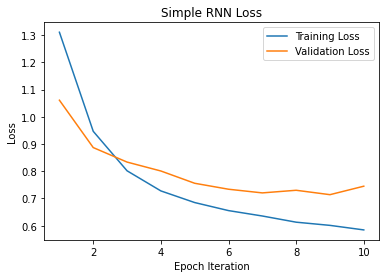

In [511]:
from keras.callbacks import History
import matplotlib.pyplot as plt

# Grabbing info from the fit
training_loss = hist.history['loss']
validation_loss = hist.history['val_loss']
epoch_range = range(1, epochs+1)

# Plotting the data
plt.figure()
plt.plot(epoch_range, training_loss, label='Training Loss')
plt.plot(epoch_range, validation_loss, label='Validation Loss')
#plt.xticks(np.arange(2, 11, 2))
plt.ylabel('Loss')
plt.xlabel('Epoch Iteration')
plt.title('Simple RNN Loss')
plt.legend()
plt.show()

In [453]:
# Obtain predictions
clean_test = tokenizer.texts_to_sequences(z_test)
pad_test = pad_sequences(clean_test)
padded_test = pad_sequences(clean_test, maxlen=max(pad_test.shape[1], maxlength))
padded_test = np.asarray(padded_test).astype(np.int)
predictions = model1.predict(padded_test)
classes = np.argmax(predictions, axis=1)
mood1 = []

for i in range(len(classes)):
    mood1.append(sentiments[classes[i]])

print('Class labels for simple RNN: ' + str(classes[:10]))

print('Sentiments for simple RNN: \n' + str(mood1[:10]))


Class labels for simple RNN: [1 2 3 2 3 2 2 3 1 4]
Sentiments for simple RNN: 
['Extremely Positive', 'Negative', 'Neutral', 'Negative', 'Neutral', 'Negative', 'Negative', 'Neutral', 'Extremely Positive', 'Positive']


In [ ]:
import csv

# create CSV file for Kaggle submission
# Note encoding problems so I manually pasted tweets in
row_list = [['OriginalTweet', 'Sentiment']]
tweets = test_data['OriginalTweet'].values
for i in range(len(mood1)):
    row = [None, mood1[i]]
    row_list.append(row)

print(row_list[1:5])

with open('submission1.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerows(row_list)


In [456]:
# f score obtained from kaggle, as they did not provide test data labels
score1 = 0.80940
print('F1 Score for simple RNN: ' + str(score1))

F1 Score for simple RNN: 0.8094


### Section 2.2: Bidirectional RNN

In [457]:
# parameters to modify
embed_size = 64
epochs = 10
batch_size = 64
input = len(vocab.keys())+1
lr = 0.001

In [458]:
from keras import layers
from keras.layers import Embedding, LSTM, Dense, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import SGD

# build the bidirectional RNN
model2 = keras.Sequential()
model2.add(Embedding(input, embed_size))
model2.add(Bidirectional(LSTM(embed_size, dropout=0.3)))
model2.add(Dense(5, activation='softmax'))
model2.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_61 (Embedding)     (None, None, 64)          320000    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_61 (Dense)             (None, 5)                 645       
Total params: 386,693
Trainable params: 386,693
Non-trainable params: 0
_________________________________________________________________


In [459]:
hist2 = model2.fit(
    x = padded_train,
    y = x_label,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (padded_valid, y_label)
)

Epoch 1/10
483/483 [==============================] - 89s 159ms/step - loss: 1.2629 - accuracy: 0.4529 - val_loss: 1.0401 - val_accuracy: 0.5534
Epoch 2/10
483/483 [==============================] - 71s 148ms/step - loss: 0.8611 - accuracy: 0.6697 - val_loss: 0.8286 - val_accuracy: 0.6884
Epoch 3/10
483/483 [==============================] - 71s 147ms/step - loss: 0.7377 - accuracy: 0.7337 - val_loss: 0.8343 - val_accuracy: 0.6841
Epoch 4/10
483/483 [==============================] - 83s 171ms/step - loss: 0.6761 - accuracy: 0.7646 - val_loss: 0.8020 - val_accuracy: 0.7152
Epoch 5/10
483/483 [==============================] - 82s 169ms/step - loss: 0.6365 - accuracy: 0.7840 - val_loss: 0.7572 - val_accuracy: 0.7351
Epoch 6/10
483/483 [==============================] - 78s 162ms/step - loss: 0.6082 - accuracy: 0.7939 - val_loss: 0.7386 - val_accuracy: 0.7416
Epoch 7/10
483/483 [==============================] - 82s 170ms/step - loss: 0.5827 - accuracy: 0.8059 - val_loss: 0.7252 - val_ac

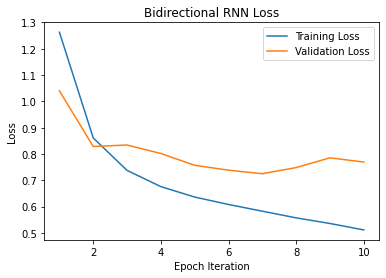

In [512]:
# Grabbing info from the fit
training_loss = hist2.history['loss']
validation_loss = hist2.history['val_loss']
epoch_range = range(1, epochs+1)

# Plotting the data
plt.figure()
plt.plot(epoch_range, training_loss, label='Training Loss')
plt.plot(epoch_range, validation_loss, label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch Iteration')
plt.title('Bidirectional RNN Loss')
plt.legend()
plt.show()

In [491]:
# Obtain predictions
clean_test = tokenizer.texts_to_sequences(z_test)
pad_test = pad_sequences(clean_test)
padded_test = pad_sequences(clean_test, maxlen=max(pad_test.shape[1], maxlength))
padded_test = np.asarray(padded_test).astype(np.int)
predictions = model2.predict(padded_test)
classes = np.argmax(predictions, axis=1)
mood2 = []

for i in range(len(classes)):
    mood2.append(sentiments[classes[i]])


print('Class labels for Bidirectional RNN: ' + str(classes[:10]))
print('Sentiments for Bidrectional RNN: \n' + str(mood2[:10]))


Class labels for Bidirectional RNN: [1 0 3 2 3 2 2 3 1 4]
Sentiments for Bidrectional RNN: 
['Extremely Positive', 'Extremely Negative', 'Neutral', 'Negative', 'Neutral', 'Negative', 'Negative', 'Neutral', 'Extremely Positive', 'Positive']


In [464]:
# create CSV file for Kaggle submission
# Note encoding utf-8 problems so I manually pasted tweets in
row_list = [['OriginalTweet', 'Sentiment']]
for i in range(len(mood2)):
    row = [None, mood2[i]]
    row_list.append(row)

print(row_list[1:5])

with open('submission2.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerows(row_list)

[[None, 'Extremely Positive'], [None, 'Extremely Negative'], [None, 'Neutral'], [None, 'Negative']]


In [465]:
# f score obtained from kaggle, as they did not provide test data labels
score2 = 0.80106
print('F1 Score for Bidrectional RNN: ' + str(score2))

F1 Score for Bidrectional RNN: 0.80106


### Section 2.3: 1D Covnvulational Neural Network

In [466]:
# parameters to modify
embed_size = 64
epochs = 10
batch_size = 64
input = len(vocab.keys()) + 1
lr = 0.001

In [503]:
from keras.layers import GlobalMaxPooling1D, Conv1D, Conv2D, Input, Reshape, MaxPool2D, Concatenate, Flatten, Dropout
from keras import regularizers
from keras.models import Model
# specify the input of each layer and output of each layer

model3 = keras.Sequential()
model3.add(Embedding(input, maxlength, input_length=maxlength, trainable=True))
model3.add(Dropout(0.4))
model3.add(Conv1D(filters=embed_size, kernel_size=20, padding='valid', activation='relu', strides=1, 
                    kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),
                    bias_regularizer=regularizers.l2(2e-3)))
model3.add(GlobalMaxPooling1D())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(5, activation='softmax'))
model3.summary()
model3.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_80 (Embedding)     (None, 41, 41)            205000    
_________________________________________________________________
dropout_5 (Dropout)          (None, 41, 41)            0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 22, 64)            52544     
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 64)                0         
_________________________________________________________________
dense_80 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 5)               

In [504]:
hist3 = model3.fit(
    x = padded_train,
    y = x_label,
    epochs = epochs,
    validation_data = (padded_valid, y_label)
)

Epoch 1/10
965/965 [==============================] - 15s 14ms/step - loss: 1.6165 - accuracy: 0.3285 - val_loss: 1.4647 - val_accuracy: 0.4126
Epoch 2/10
965/965 [==============================] - 15s 15ms/step - loss: 1.4131 - accuracy: 0.4520 - val_loss: 1.3254 - val_accuracy: 0.5274
Epoch 3/10
965/965 [==============================] - 15s 16ms/step - loss: 1.2300 - accuracy: 0.5706 - val_loss: 1.1588 - val_accuracy: 0.6209
Epoch 4/10
965/965 [==============================] - 15s 16ms/step - loss: 1.0916 - accuracy: 0.6463 - val_loss: 1.0746 - val_accuracy: 0.6570
Epoch 5/10
965/965 [==============================] - 16s 17ms/step - loss: 1.0162 - accuracy: 0.6820 - val_loss: 1.0567 - val_accuracy: 0.6675
Epoch 6/10
965/965 [==============================] - 14s 15ms/step - loss: 0.9718 - accuracy: 0.7060 - val_loss: 1.0483 - val_accuracy: 0.6893
Epoch 7/10
965/965 [==============================] - 15s 16ms/step - loss: 0.9443 - accuracy: 0.7191 - val_loss: 1.0400 - val_accuracy:

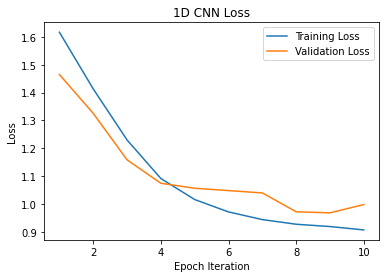

In [513]:
# Grabbing info from the fit
training_loss = hist3.history['loss']
validation_loss = hist3.history['val_loss']
epoch_range = range(1, epochs+1)

# Plotting the data
plt.figure()
plt.plot(epoch_range, training_loss, label='Training Loss')
plt.plot(epoch_range, validation_loss, label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch Iteration')
plt.title('1D CNN Loss')
plt.legend()
plt.show()

In [509]:
# Obtain predictions
clean_test = tokenizer.texts_to_sequences(z_test)
pad_test = pad_sequences(clean_test)
padded_test = pad_sequences(clean_test, maxlen=max(pad_test.shape[1], maxlength))
padded_test = np.asarray(padded_test).astype(np.int)
predictions = model3.predict(padded_test)
classes = np.argmax(predictions, axis=1)
mood3 = []

for i in range(len(classes)):
    mood3.append(sentiments[classes[i]])


print('Class labels for 1D CNN: ' + str(classes[:10]))
print('Sentiments for 1D CNN: \n' + str(mood3[:10]))

Class labels for 1D CNN: [4 2 3 2 3 2 2 3 1 3]
Sentiments for 1D CNN: 
['Positive', 'Negative', 'Neutral', 'Negative', 'Neutral', 'Negative', 'Negative', 'Neutral', 'Extremely Positive', 'Neutral']


In [508]:
# create CSV file for Kaggle submission
# Note encoding utf-8 problems so I manually pasted tweets in
row_list = [['OriginalTweet', 'Sentiment']]
for i in range(len(mood3)):
    row = [None, mood3[i]]
    row_list.append(row)

print(row_list[1:5])

with open('submission3.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerows(row_list)

[[None, 'Positive'], [None, 'Negative'], [None, 'Neutral'], [None, 'Negative']]


In [510]:
# f score obtained from kaggle, as they did not provide test data labels
score3 = 0.78292
print('F1 Score for 1D CNN: ' + str(score3))

F1 Score for 1D CNN: 0.78292
